# Distribution fitting with pytorch 

## Overview 
This is a POC of using pytorch to do distribution fitting. This might be useful because it might give us more control over things like parameter initialization, learning rate, and optimization configuration. Also, it makes it easy to track how estimates change during the optimization process. This can help us identify cases where we're getting stuck in local minima. 

- Use the likelihood function of weibull 2p as the loss function 
- The "model" is really just the shape and scale params. During training, we run N iterations. In each iteration, we use the current estimated params to evaluate the loss, calculate gradient, and take an optimization step. 
- After some experimentation, the following config seems to work well: 
  - Initialize weights/params with `weights = torch.distributions.Uniform(0, 4).sample((2,))`
  - Use optimizer `torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)`
  - Use n=2000 iterations in training loop (similar to epochs in more standard ML problems)


Other things to try: 
- For both LBFGS and Adam, how to deal with the case where param estimate becomes negative? When that happens at a certain optimization step, the loss for that step in nan, and then all further steps fail.
- Check why Adam can't deal estimate large scale values (larger than 1.0). Confirm that LBFGS can. 
- Set up tracking of validation loss + early stopping
- Fit mixtures of Weibulls instead of single weibulls. See function `weibull_mixture_nll` below. We would also have to change the `Model` class to have six weights: `p1, p2, shape1, shape2, scale1, scale2`. However, keep in mind that the goal is not perfect fit. Focus on interpretability and business purpose over perfect fit. 





## References: 
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)
- [pytorch Adam vs LBFGS](https://soham.dev/posts/linear-regression-pytorch/)

In [1]:
import numpy as np
from scipy.stats import weibull_min, beta, gaussian_kde
import torch
import torch.nn as nn
from torch.functional import F
from torch.autograd import Variable
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data setup 

In [2]:
np.random.seed(2023)

n = 100
shape = 9.98
scale = 4890

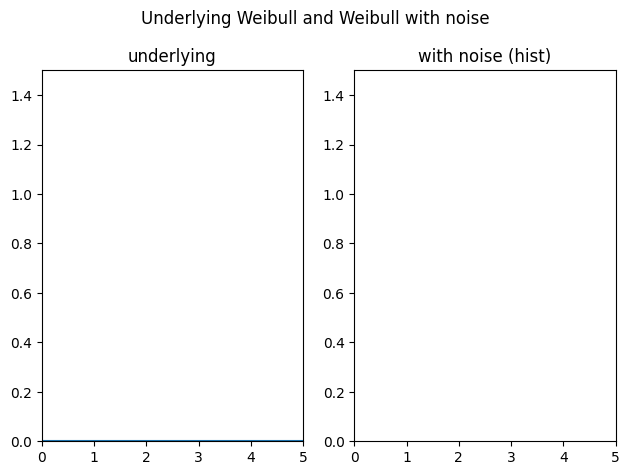

In [3]:
#generate points for weibull, set location parameter to 0 - this is 2-parameter because loc is 0
weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=n)

#add noise, mean = 0, sd = 0.1 for the same sample size
noise = np.random.normal(0, 0.1, n)  
weibull_data = weibull_data + noise
#all positive data
weibull_data = np.abs(weibull_data) + 1e-4

#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 5, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data, bins=10, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 5)
    ax[idx].set_ylim(0, 1.5)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

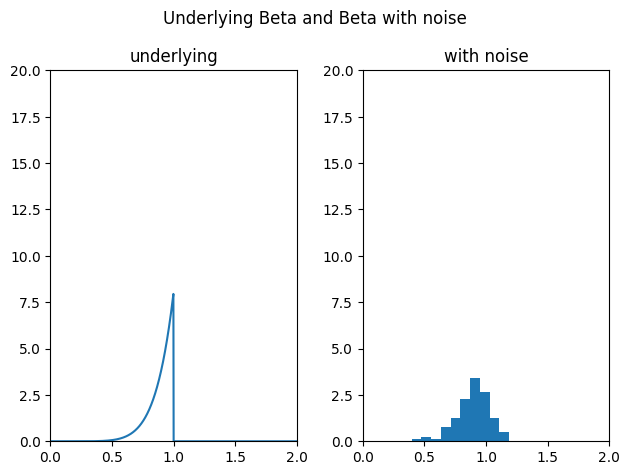

In [4]:
#generate non-weibull data, following beta distribution
beta_data = beta.rvs(a=8, b=1, size=n)
#add noise
beta_data = beta_data + noise
#all positive data
beta_data = np.abs(beta_data)

#generate the pdf with the same parameters that were used for generating the data
curve_x = np.linspace(0, 2, 1000)
beta_pdf = beta.pdf(curve_x, a=8, b=1)

title='Underlying Beta and Beta with noise'
subs = ['underlying', 'with noise']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, beta_pdf)
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 2.0)
    ax[idx].set_ylim(0, 20.0)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

****
# Utility functions 

In [5]:
def plot_weibull_distributions(params1, params2):
    shape1, scale1 = params1
    shape2, scale2 = params2
    
    # Create Weibull distribution objects
    weibull_dist1 = weibull_min(c=shape1, scale=scale1)
    weibull_dist2 = weibull_min(c=shape2, scale=scale2)
    
    # Generate x values for the plot
    x = np.linspace(0, max(scale1, scale2) * 2, 1000)
    
    # Calculate probability density function values for each distribution
    pdf1 = weibull_dist1.pdf(x)
    pdf2 = weibull_dist2.pdf(x)
    
    # Plot the distributions
    plt.plot(x, pdf1, label=f'Weibull ({shape1:.2f}, {scale1:.2f})')
    plt.plot(x, pdf2, label=f'Weibull ({shape2:.2f}, {scale2:.2f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Weibull Distributions')
    plt.show()

****
# Model setup 

In [6]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 4).sample((2,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, a 2-parameter Weibull
        distribution (f(x) = (k / lambda) * (x / lambda)^(k - 1) * exp(-(x / lambda)^k)),
        """
        lambda_, k = self.weights
        weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
        
        return weibull_pdf


In [7]:
def train_loop(model, optimizer, data_tensor, n=1000): 
    losses = []
    print('scale, shape, loss \n')
    for i in range(n):
        preds = model(data_tensor)
        # loss = F.mse_loss(preds, data_tensor).sqrt()  # todo: use neg log likelihood? 
        lambda_, k = model.weights
        loss = weibull_nll(data_tensor, lambda_, k)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss) 
        if i % 100 == 0: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        
    return losses

In [8]:
def weibull_nll(data, lambda_, k): 
    log_likelihood = torch.sum(torch.log(k / lambda_) + (k - 1) * torch.log(data / lambda_) - (data / lambda_) ** k)
    nll = -log_likelihood
    return nll

In [9]:
def weibull_mixture_nll(data, alphas, betas, pis):
    # todo: verify that this is correct 
    data = data.unsqueeze(1).expand_as(alphas)
    likelihood = pis * torch.exp((torch.log(data) - torch.log(alphas)) * betas - (data / alphas) ** betas)
    log_likelihood = torch.log(likelihood.sum(dim=1)).sum()
    nll = -log_likelihood
    return nll

****
# Using Adam optimizer on Weibull data 

scale, shape, loss 

iter 0: 0.42775630950927734, 3.7758219242095947, 2.179576999754218e+17
iter 100: 0.6664881110191345, 3.5025861263275146, 3034642129074633.0
iter 200: 0.7047631740570068, 3.4416825771331787, 1452480971711340.5
iter 300: 0.7291694283485413, 3.4005374908447266, 898345665623364.2
iter 400: 0.7468794584274292, 3.3695387840270996, 630383717278068.5
iter 500: 0.7606794834136963, 3.3447060585021973, 476687314010386.5
iter 600: 0.7719269394874573, 3.3240199089050293, 378701889331421.5
iter 700: 0.7813810706138611, 3.3063173294067383, 311577453239453.9
iter 800: 0.7895094156265259, 3.290863275527954, 263125005198884.4
iter 900: 0.7966192960739136, 3.277167320251465, 226740608346228.62
iter 1000: 0.8029236197471619, 3.264881134033203, 198552219794543.66
iter 1100: 0.8085753321647644, 3.253754138946533, 176162468676901.62
iter 1200: 0.8136884570121765, 3.243594169616699, 158006327894257.75
iter 1300: 0.8183501362800598, 3.2342529296875, 143024720315519.16
iter 1400: 0.82262796

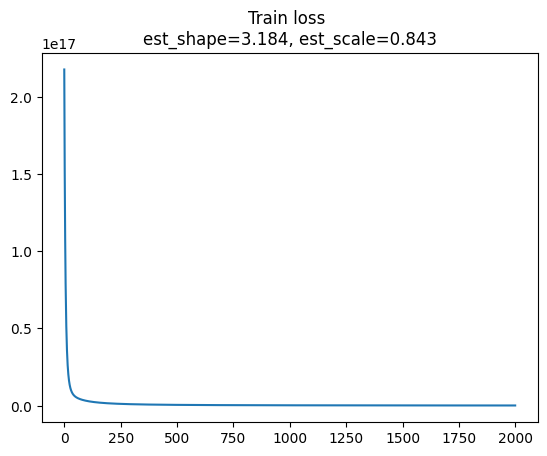

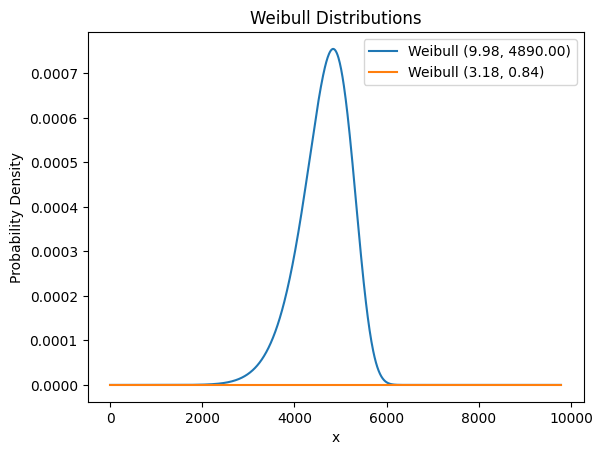

Actual shape=9.98


In [10]:
# min-max scale to speed up convergence. This means we won't get correctly estimated scale param, 
# but shape param will remain same. 
# weibull_data_scaled = [(x - weibull_data.min()) / (weibull_data.max() - weibull_data.min()) for x in weibull_data]
weibull_tensor = torch.tensor(weibull_data, dtype=float).reshape(-1,1)

m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=weibull_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

# Using Adam optimizer on Beta data 

scale, shape, loss 

iter 0: 0.8147406578063965, 3.316964864730835, -8.526898249660917
iter 100: 0.9247010350227356, 4.26955509185791, -37.17340932764379
iter 200: 0.9303244948387146, 5.033254623413086, -46.80717682211228
iter 300: 0.9349558353424072, 5.657894611358643, -52.34385937009325
iter 400: 0.9385928511619568, 6.167884349822998, -55.57858158211704
iter 500: 0.9414119720458984, 6.574490070343018, -57.43577324516602
iter 600: 0.9435647130012512, 6.891537189483643, -58.48119993519734
iter 700: 0.9451918005943298, 7.13488245010376, -59.06072956282826
iter 800: 0.9464107751846313, 7.319293975830078, -59.37756709447411
iter 900: 0.9473168849945068, 7.457502365112305, -59.54839018048169
iter 1000: 0.9479849338531494, 7.560044765472412, -59.63925246038782
iter 1100: 0.9484738707542419, 7.635422229766846, -59.686935292803014
iter 1200: 0.9488289952278137, 7.690357685089111, -59.71165230899062
iter 1300: 0.9490852355957031, 7.73007869720459, -59.72429881580425
iter 1400: 0.94926875829696

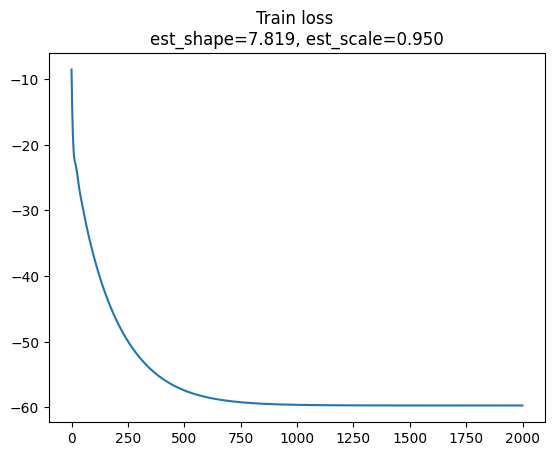

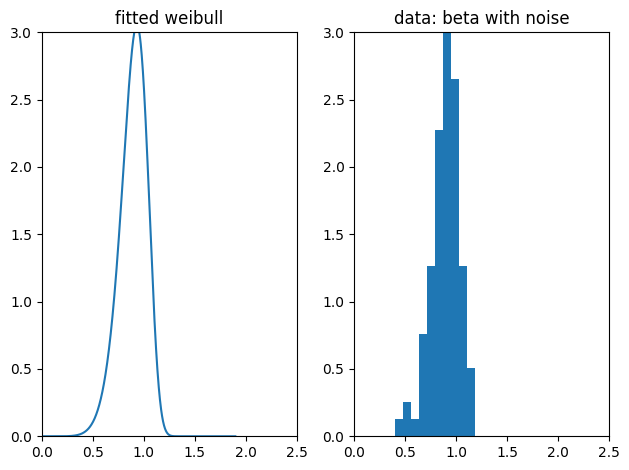

In [11]:
beta_tensor = torch.tensor(beta_data, dtype=float).reshape(-1,1)

m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=beta_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
# print(f'\nActual params: shape={shape}, scale={scale}')
# print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
# print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()


txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()


****
# Using LBFGS optimizer on Weibull data 

scale, shape, loss 

iter 0: 2.4056601524353027, 1.0958592891693115, 397410.9794431458
iter 0: 2.411336660385132, 1.0015357732772827, 194242.21753941773
iter 0: 2.411785364151001, 0.9925384521484375, 181439.35581256216
iter 0: 2.412323474884033, 0.9798164367675781, 164773.37083547193
iter 0: 2.4127581119537354, 0.9672685265541077, 149845.33479614058
iter 0: 2.413097620010376, 0.9547053575515747, 136262.8821382475
iter 0: 2.413341999053955, 0.9421364068984985, 123914.38712630412
iter 0: 2.4134912490844727, 0.9295614957809448, 112687.5307946128
iter 0: 2.413545608520508, 0.916981041431427, 102480.72701415382
iter 0: 2.4135053157806396, 0.904395341873169, 93201.47439659551
iter 0: 2.4133706092834473, 0.8918046951293945, 84765.64725537642
iter 0: 2.4131417274475098, 0.8792095184326172, 77096.80797010327
iter 0: 2.412818670272827, 0.8666102290153503, 70125.42998522882
iter 0: 2.4124019145965576, 0.8540070652961731, 63788.17200240972
iter 0: 2.411891460418701, 0.8414005637168884, 58027.58507

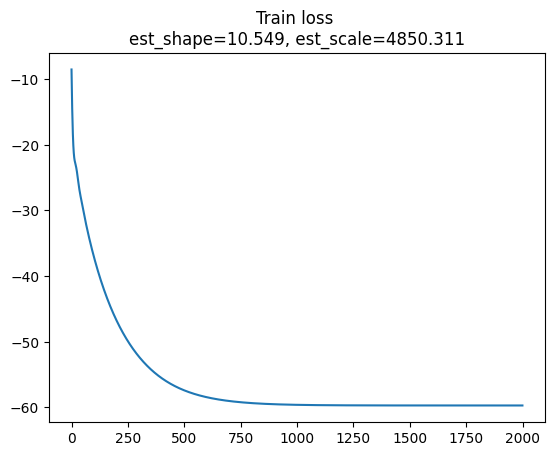

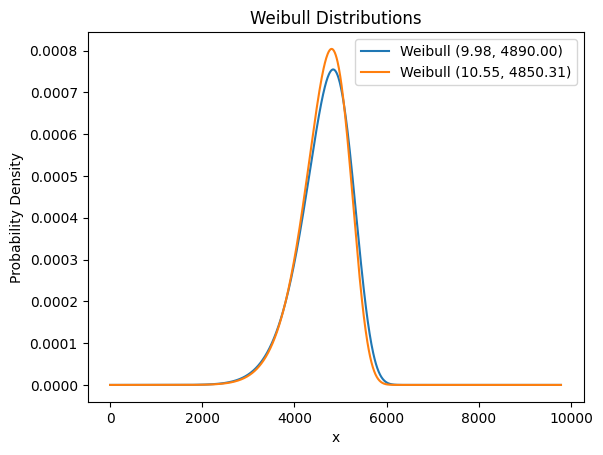

Actual shape=9.98


In [12]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(weibull_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(weibull_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

****
# Using LBFGS optimizer on Beta data 

scale, shape, loss 

iter 0: 3.1791372299194336, 2.017817497253418, 183.9788039638762
iter 0: 3.133272647857666, 1.9636820554733276, 177.69054166096745
iter 0: 2.9602301120758057, 1.8542451858520508, 161.3590701906971
iter 0: 2.660445213317871, 1.753091812133789, 139.94062776764162
iter 0: 2.0100526809692383, 1.619347333908081, 99.93427217657901
iter 0: 0.5969672799110413, 1.4230278730392456, 75.54033569908
iter 0: 0.7052125930786133, 1.4390913248062134, 60.59908833866883
iter 0: 0.7171592116355896, 1.4491190910339355, 59.06830834816287
iter 0: 0.7426782846450806, 1.4803677797317505, 55.477713718787044
iter 0: 0.7729815244674683, 1.5275657176971436, 51.01731171820326
iter 0: 0.8051015138626099, 1.5872429609298706, 46.18479546114851
iter 0: 0.836217999458313, 1.6541262865066528, 41.45474534518888
iter 0: 0.8648419380187988, 1.724343180656433, 37.066395766441815
iter 0: 0.890526533126831, 1.7959715127944946, 33.07286341491344
iter 0: 0.9133285880088806, 1.8684314489364624, 29.43744141695

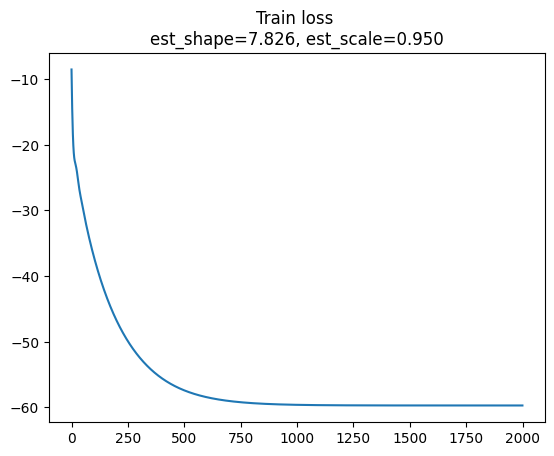

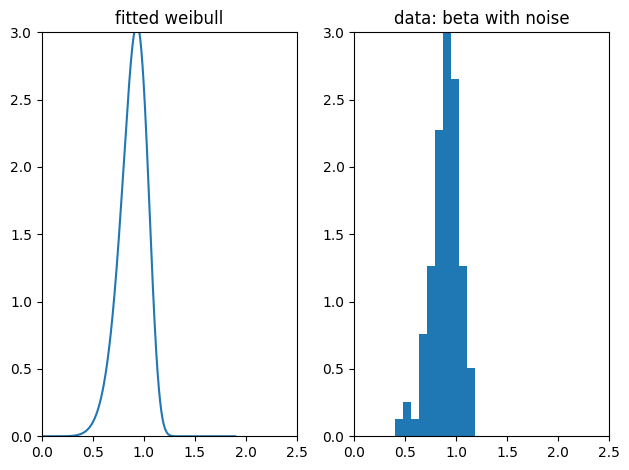

In [13]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(beta_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(beta_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}' 
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()

****
# Random stuff 

/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


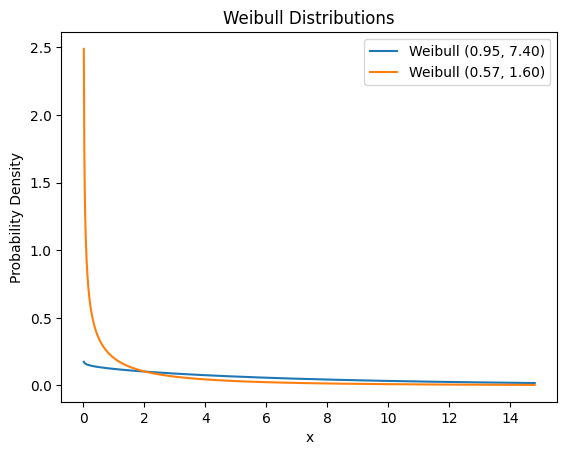

In [14]:
plot_weibull_distributions((.95, 7.4), (.57, 1.6))